In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import accuracy_score

In [2]:
# создаем массив фактических значений (классов)
# зависимой переменной
classes = np.array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 
                    0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [3]:
# создаем массив спрогнозированных вероятностей 
# положительного класса
proba = np.array([0.92, 0.9, 0.88, 0.85, 0.82, 
                  0.79, 0.75, 0.73, 0.72, 0.7, 
                  0.6, 0.59, 0.58, 0.53, 0.52, 
                  0.4, 0.33, 0.32, 0.24, 0.18])

In [4]:
# пишем функцию, которая будет строить ROC-кривую
def _binary_clf_curve(y_true, y_score):
    """
    Вычисляем количество истинно положительных и ложно
    положительных для каждого порогового значения
    вероятности положительного класса; предполагается, что
    наблюдение положительного класса всегда имеет метку 1

    Параметры
    ----------
    y_true : одномерный массив формы [n_samples]
        Фактические метки (классы) зависимой переменной

    y_score : одномерный массив формы [n_samples]
        Спрогнозированные вероятности положительного класса

    Возвращает
    -------
    tps : одномерный массив        
        Количество истинно положительных случаев (tps), индекс i фиксирует
        количество наблюдений положительного класса, которые получили
        оценку > = thresholds[i].
        Общее количество наблюдений положительного класса равно
        tps[-1] (таким образом, количество ложно отрицательных
        случаев определяется по формуле tps[-1] - tps)

    fps : одномерный массив
        Количество ложно положительных случаев (fps), индекс i фиксирует
        количество наблюдений отрицательного класса, которые получили
        оценку > = thresholds[i].
        Общее количество наблюдений отрицательного класса равно
        fps[-1] (таким образом, количество истинно отрицательных
        случаев определяется по формуле fps[-1] - fps)

    thresholds : одномерный массив
        Пороговые значения спрогнозированной вероятности
        положительного класса, отсортированные по убыванию

    Ссылки
    ----------
    Github: scikit-learn _binary_clf_curve
    - https://github.com/scikit-learn/scikit-learn/blob/ab93d65/sklearn/metrics/ranking.py#L263
    """

    # получаем индексы вероятностей положительного класса,
    # отсортированных по убыванию 
    desc_score_indices = np.argsort(y_score)[::-1]
    # сортируем вероятности с помощью индексов
    y_score = y_score[desc_score_indices]
    # сортируем метки с помощью индексов
    y_true = y_true[desc_score_indices]

    # функция np.diff() возвращает n-ю разность элементов массива 
    # (по умолчанию n=1), которая так же может быть вычислена 
    # вдоль указанной оси или осям. с помощью np.where() получаем 
    # индексы порогов
    distinct_indices = np.where(np.diff(y_score))[0]
    # вычисляем индекс последнего порога
    end = np.array([y_true.size - 1])
    # добавляем этот индекс в конец массива с индексами порогов
    threshold_indices = np.hstack((distinct_indices, end))

    # получаем пороговые значения вероятности положительного класса
    # и количество истинно положительных случаев
    thresholds = y_score[threshold_indices]
    tps = np.cumsum(y_true)[threshold_indices]

    # (1 + threshold_indices) = количество положительных наблюдений
    # в каждом индексе, таким образом, количество наблюдений минус
    # количество истинно положительных = количество ложно положительных
    fps = (1 + threshold_indices) - tps
    return tps, fps, thresholds

In [5]:
# применяем нашу функцию _binary_clf_curve()
tps, fps, thresholds = _binary_clf_curve(classes, proba)
print('пороги:', thresholds)
print('количество истинно положительных:', tps)
print('количество ложно положительных:', fps)

пороги: [0.92 0.9  0.88 0.85 0.82 0.79 0.75 0.73 0.72 0.7  0.6  0.59 0.58 0.53
 0.52 0.4  0.33 0.32 0.24 0.18]
количество истинно положительных: [1 2 3 3 4 5 5 6 7 7 7 7 7 7 8 8 8 8 8 8]
количество ложно положительных: [ 0  0  0  1  1  1  2  2  2  3  4  5  6  7  7  8  9 10 11 12]


доля истинно положительных:
 [0.    0.125 0.25  0.375 0.375 0.5   0.625 0.625 0.75  0.875 0.875 0.875
 0.875 0.875 0.875 1.    1.    1.    1.    1.    1.   ]

доля ложно положительных:
 [0.         0.         0.         0.         0.08333333 0.08333333
 0.08333333 0.16666667 0.16666667 0.16666667 0.25       0.33333333
 0.41666667 0.5        0.58333333 0.58333333 0.66666667 0.75
 0.83333333 0.91666667 1.        ]


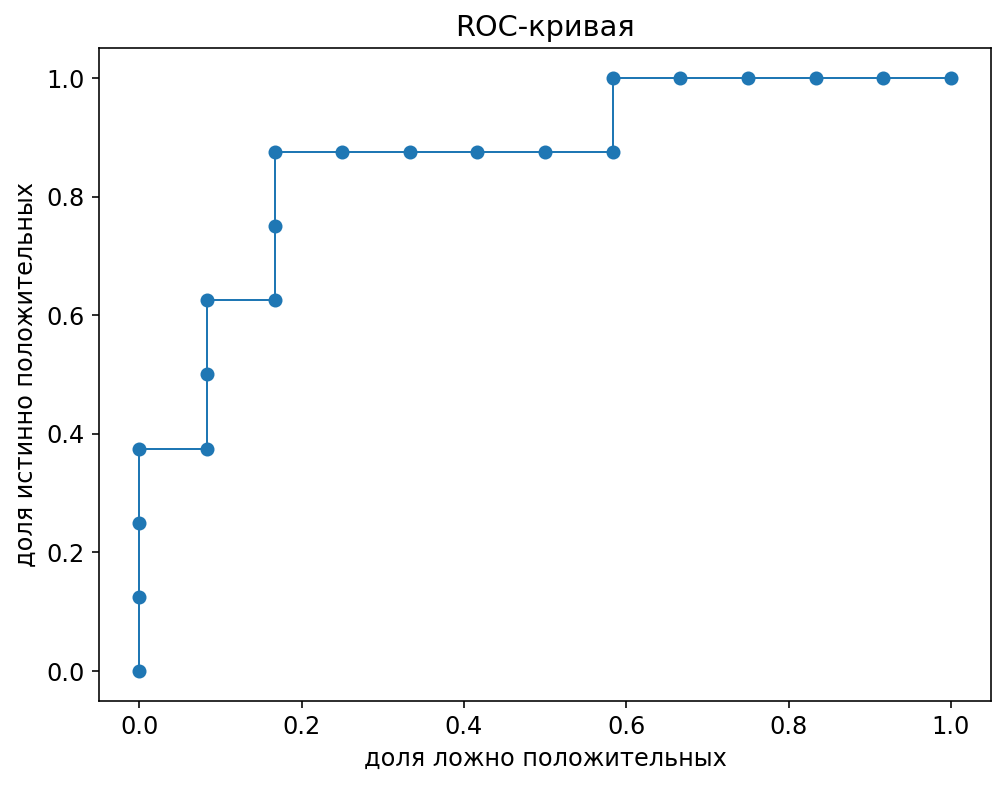

In [6]:
# преобразовываем количество в долю, добавляем 0
# к истинно положительным и ложно положительным,
# чтобы ROC-кривая брала начало в точке (0, 0)
tpr = np.hstack((0, tps / tps[-1]))
fpr = np.hstack((0, fps / fps[-1]))
print('доля истинно положительных:\n', tpr)
print('')
print('доля ложно положительных:\n', fpr)

# строим ROC-кривую
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

fig = plt.figure()
plt.plot(fpr, tpr, marker='o', lw=1)
plt.xlabel('доля ложно положительных')
plt.ylabel('доля истинно положительных')
plt.title('ROC-кривая')
plt.show()

In [7]:
# запишем массив меток и массив вероятностей
# для наших экспериментов
classes_ = classes
proba_ = proba

In [8]:
# получаем индексы вероятностей положительного класса,
# отсортированных по убыванию 
desc_score_indices = np.argsort(proba_)[::-1]
desc_score_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [9]:
# сортируем вероятности с помощью индексов
y_score = proba_[desc_score_indices]
y_score

array([0.92, 0.9 , 0.88, 0.85, 0.82, 0.79, 0.75, 0.73, 0.72, 0.7 , 0.6 ,
       0.59, 0.58, 0.53, 0.52, 0.4 , 0.33, 0.32, 0.24, 0.18])

In [10]:
# сортируем метки с помощью индексов
y_true = classes_[desc_score_indices]
y_true

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [11]:
# функция np.diff() возвращает n-ю разность элементов массива 
# (по умолчанию n=1), которая так же может быть вычислена 
# вдоль указанной оси или осям
np.diff(y_score)

array([-0.02, -0.02, -0.03, -0.03, -0.03, -0.04, -0.02, -0.01, -0.02,
       -0.1 , -0.01, -0.01, -0.05, -0.01, -0.12, -0.07, -0.01, -0.08,
       -0.06])

In [12]:
# с помощью np.where() получаем индексы уникальных порогов
distinct_indices = np.where(np.diff(y_score))[0]
distinct_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [13]:
# вычисляем индекс последнего порога
end = np.array([y_true.size - 1])
end

array([19])

In [14]:
# добавляем этот индекс в конец массива с индексами порогов
threshold_indices = np.hstack((distinct_indices, end))
threshold_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [15]:
# получаем пороговые значения вероятности положительного класса
thresholds = y_score[threshold_indices]
thresholds

array([0.92, 0.9 , 0.88, 0.85, 0.82, 0.79, 0.75, 0.73, 0.72, 0.7 , 0.6 ,
       0.59, 0.58, 0.53, 0.52, 0.4 , 0.33, 0.32, 0.24, 0.18])

In [16]:
# получаем количество истинно положительных случаев 
# для каждого порога
tps = np.cumsum(y_true)[threshold_indices]
tps

array([1, 2, 3, 3, 4, 5, 5, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8])

In [17]:
# получаем количество ложно положительных случаев 
# для каждого порога
fps = (1 + threshold_indices) - tps
fps

array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  4,  5,  6,  7,  7,  8,  9,
       10, 11, 12])

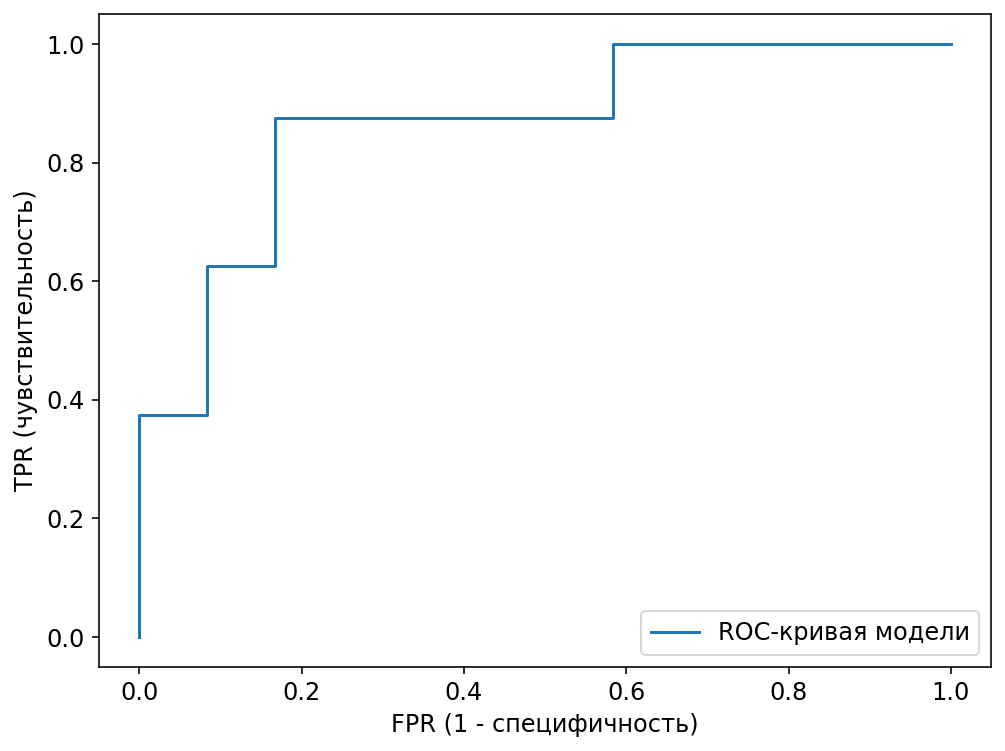

In [18]:
# из модуля sklearn.metrics импортируем функцию roc_curve()
from sklearn.metrics import roc_curve
# вычисляем значения FPR и TPR для всех возможных 
# порогов отсечения, передав функции roc_curve()
# в качестве аргументов фактические значения 
# зависимой переменной и вероятности 
fpr, tpr, thresholds = roc_curve(classes, proba)
# создаем заголовок ROC-кривой
plt.plot(fpr, tpr, label='ROC-кривая модели')
# задаем название для оси x
plt.xlabel('FPR (1 - специфичность)')
# задаем название для оси y
plt.ylabel('TPR (чувствительность)')
# задаем расположение легенды
plt.legend(loc=4);

In [19]:
# записываем CSV-файл в объект DataFrame
weird_data = pd.read_csv('Data/weird_roc.csv', sep=',')
weird_data.tail(10)

,fact,prob
1473,1,0.366743
1474,1,0.295093
1475,1,0.306020
1476,1,0.270486
1477,1,0.368694
1478,1,0.271503
1479,1,0.350956
1480,1,0.355348
1481,1,0.283862
1482,1,0.295863


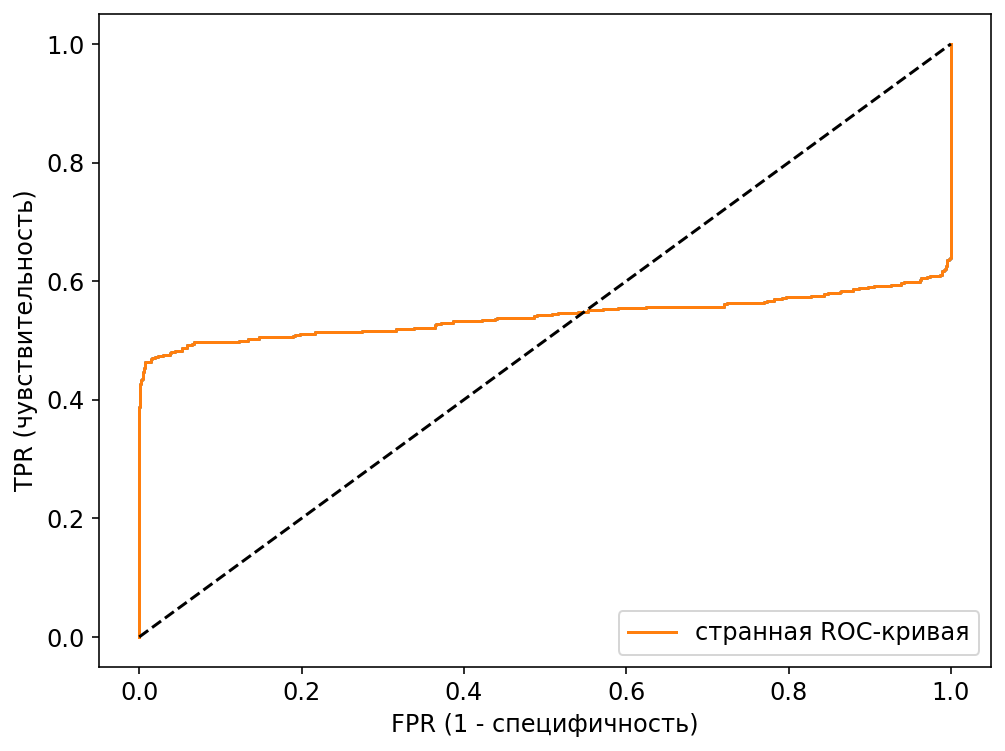

In [20]:
# строим ROC-кривую
fpr, tpr, thresholds = roc_curve(weird_data['fact'], weird_data['prob'])
plt.plot(fpr, tpr)
plt.xlabel('FPR (1 - специфичность)')
plt.ylabel('TPR (чувствительность)')
plt.plot(fpr, tpr, label='странная ROC-кривая')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=4);

In [21]:
# пишем функцию, которая будет вычислять AUC-ROC
def _roc_auc_score(y_true, y_score):
    """
    Вычисляет AUC-ROC

    Параметры
    ----------
    y_true : одномерный массив формы [n_samples]
        Фактические метки (классы) зависимой переменной

    y_score : одномерный массив формы [n_samples]
        Спрогнозированные вероятности положительного класса

    Возвращает
    -------
    auc : float
    """

    # убедимся, что зависимая переменная является бинарной
    if np.unique(y_true).size != 2:
        raise ValueError('Лишь два класса должно быть в y_true.')
    
    # получаем с помощью функции _binary_clf_curve()
    # значения чувствительности и 1 - специфичности
    tps, fps, _ = _binary_clf_curve(y_true, y_score)

    # переходим к долям
    tpr = tps / tps[-1]
    fpr = fps / fps[-1]

    # вычисляем AUC с помощью метода трапеций
    # добавляем 0 для обеспечения соответствия длины
    zero = np.array([0])
    tpr_diff = np.hstack((np.diff(tpr), zero))
    fpr_diff = np.hstack((np.diff(fpr), zero))
    auc = np.dot(tpr, fpr_diff) + np.dot(tpr_diff, fpr_diff) / 2
    return auc

In [22]:
# вычисляем значение AUC-ROC, передав нашей функции 
# _roc_auc_score() в качестве аргументов фактические 
# значения зависимой переменной и вероятности 
auc_roc = _roc_auc_score(classes, proba)
# печатаем AUC-ROC
auc_roc

0.8645833333333333

In [23]:
# импортируем функцию roc_auc_score()
from sklearn.metrics import roc_auc_score
# вычисляем значение AUC-ROC, передав функции 
# roc_auc_score() в качестве аргументов фактические 
# значения зависимой переменной и вероятности 
auc_roc = roc_auc_score(classes, proba)
# печатаем AUC-ROC
auc_roc

0.8645833333333333

In [24]:
# импортируем класс RandomState
from numpy.random import RandomState

In [25]:
# создаем массив меток классов зависимой переменной
classes = np.array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
                    0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

# создаем массив спрогнозированных вероятностей 
# положительного класса
proba = np.array([0.92, 0.9, 0.88, 0.85, 0.82, 
                  0.79, 0.75, 0.73, 0.72, 0.7, 
                  0.6, 0.59, 0.58, 0.53, 0.52, 
                  0.4, 0.33, 0.32, 0.24, 0.18])

In [26]:
# записываем вероятности положительных 
# и отрицательных примеров 
pos = proba[np.where(classes == 1)]
neg = proba[np.where(classes == 0)]

In [27]:
# задаем стартовое значение генератора
# случайных чисел для воспроизводимости
seed = 14

# извлекаем случайным образом положительные и  
# отрицательные примеры и вычисляем долю случаев, 
# когда положительные примеры получили более 
# высокую вероятность, чем отрицательные
size = 200000
random_pos = RandomState(seed).choice(pos, size=size)
random_neg = RandomState(seed).choice(neg, size=size)
p = np.sum(random_pos > random_neg) / size
p

0.86439

In [28]:
# вычислим AUC вручную
denominator = np.bincount(classes)[0] * np.bincount(classes)[1]
numerator = (12 + 12 + 12 + 11 + 11 + 10 + 10 + 5)
manually_calculated_auc = numerator / denominator
print('AUC-ROC {0:.4f}'.format(manually_calculated_auc))

AUC-ROC 0.8646


In [29]:
# модифицируем массив спрогнозированных вероятностей 
# положительного класса
proba = np.array([0.95, 0.91, 0.84, 0.81, 0.80, 
                  0.78, 0.74, 0.72, 0.69, 0.68, 
                  0.65, 0.59, 0.57, 0.55, 0.53, 
                  0.51, 0.49, 0.45, 0.41, 0.38])

In [30]:
# вычислим AUC вручную
denominator = np.bincount(classes)[0] * np.bincount(classes)[1]
numerator = (12 + 12 + 12 + 12 + 12 + 12 + 12 + 12)
manually_calculated_auc = numerator / denominator
print('AUC-ROC {0:.4f}'.format(manually_calculated_auc))

AUC-ROC 1.0000


In [31]:
# модифицируем массив спрогнозированных вероятностей 
# положительного класса
proba = np.array([0.92, 0.9, 0.88, 0.88, 0.82, 
                  0.79, 0.75, 0.73, 0.72, 0.7, 
                  0.6, 0.59, 0.58, 0.53, 0.52, 
                  0.4, 0.33, 0.32, 0.24, 0.18])

In [32]:
# вычислим AUC вручную
denominator = np.bincount(classes)[0] * np.bincount(classes)[1]
numerator = (12 + 12 + 11.5 + 11 + 11 + 10 + 10 + 5)
manually_calculated_auc = numerator / denominator
print('AUC-ROC {0:.4f}'.format(manually_calculated_auc))

AUC-ROC 0.8594


In [33]:
# 50% неверных прогнозов и AUC-ROC 1
cl = np.array([1, 1, 1, 0, 0, 0])
pr = np.array([0.45, 0.40, 0.38, 0.35, 0.33, 0.3])
predictions = np.where(pr >= 0.5, 1, 0)
print('auc-roc', roc_auc_score(cl, pr))
print('правильность', accuracy_score(cl, predictions))

auc-roc 1.0
правильность 0.5


In [34]:
# 83% неверных прогнозов и AUC-ROC 1
cls = np.array([1, 1, 1, 1, 1, 0])
prb = np.array([0.45, 0.43, 0.38, 0.36, 0.33, 0.3])
preds = np.where(prb >= 0.5, 1, 0)
print('auc-roc', roc_auc_score(cls, prb))
print('правильность', accuracy_score(cls, preds))

auc-roc 1.0
правильность 0.16666666666666666


In [35]:
# создаем массив меток зависимой переменной (идеальный баланс) 
cl = np.hstack([np.ones(10), np.zeros(10)])
cl

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [36]:
# создаем массив вероятностей первого классификатора
pr = np.hstack([np.ones(5), np.zeros(5), .25 * np.ones(10)])
pr

array([1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

In [37]:
# создаем массив вероятностей второго классификатора
pr2 = np.hstack([np.zeros(5), np.ones(5), .25 * np.ones(10)])
pr2

array([0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

In [38]:
# смотрим AUC классификаторов
print(
    roc_auc_score(cl, pr),
    roc_auc_score(cl, pr2),
    roc_auc_score(cl, pr + pr2)
)

0.5 0.5 1.0


In [39]:
# изобразим более наглядно
results = np.column_stack((cl, pr, pr2, pr + pr2))
results

array([[1.  , 1.  , 0.  , 1.  ],
       [1.  , 1.  , 0.  , 1.  ],
       [1.  , 1.  , 0.  , 1.  ],
       [1.  , 1.  , 0.  , 1.  ],
       [1.  , 1.  , 0.  , 1.  ],
       [1.  , 0.  , 1.  , 1.  ],
       [1.  , 0.  , 1.  , 1.  ],
       [1.  , 0.  , 1.  , 1.  ],
       [1.  , 0.  , 1.  , 1.  ],
       [1.  , 0.  , 1.  , 1.  ],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.25, 0.25, 0.5 ]])